In [1]:
import requests
import bs4
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
url = "https://www.youtube.com/channel/UC4xKdmAXFh4ACyhpiQ_3qBw"
v_url = []

In [4]:
def get_video_list(url):
    page = requests.get(url).content
    data = str(page).split(' ')
    item = 'href="/watch?'
    vids = [line.replace('href="', 'https://youtube.com') for line in data if item in line] # list of all videos listed twice
    for item in vids:
        v_url.append(item.split(";")[0])
    return v_url

In [5]:
#validate the video url list
v_url=get_video_list(url)
v_url = list(set(v_url))
print v_url

['https://youtube.com/watch?v=N7E_xkAPWs0"', 'https://youtube.com/watch?v=-brF6SUXbns"', 'https://youtube.com/watch?v=NxJCSI7a8wk&amp', 'https://youtube.com/watch?v=3aZorQ1U7vM"', 'https://youtube.com/watch?v=vAXTP8HTHr8"', 'https://youtube.com/watch?v=7t2X-kMhPIA"', 'https://youtube.com/watch?v=DYLSkySSF0I"', 'https://youtube.com/watch?v=Ap2uWsJV25w"', 'https://youtube.com/watch?v=LQFsEwcCO1E"', 'https://youtube.com/watch?v=EcojyBV4QJ4"', 'https://youtube.com/watch?v=fssFXlNk6vw"', 'https://youtube.com/watch?v=XGpaK9vt0tw"', 'https://youtube.com/watch?v=kapNVurryRA"', 'https://youtube.com/watch?v=BnwB8Oh628Q"', 'https://youtube.com/watch?v=FSVVe-Inhyg"', 'https://youtube.com/watch?v=NxJCSI7a8wk"', 'https://youtube.com/watch?v=-W_VsLXmjJU"', 'https://youtube.com/watch?v=EHtFnNIIasc"', 'https://youtube.com/watch?v=2pIJoPkh9IU"', 'https://youtube.com/watch?v=u4oMEljRzBY"', 'https://youtube.com/watch?v=EcojyBV4QJ4&amp', 'https://youtube.com/watch?v=w4t_xTegGBE"', 'https://youtube.com/watc

In [6]:
def get_video_data(video_page_url):
    video_data = {}
    response = requests.get(video_page_url)
    soup = bs4.BeautifulSoup(response.text)
    #video_data['title'] = soup.select('.entry-title a[href^=https:]')[0].get_text()
    video_data['URL'] = video_page_url
    for span in soup.findAll('span',attrs={'class': 'watch-title'}):
        video_data['TITLE'] = span.text.strip()
    for script in soup.findAll('script',attrs={'type': 'application/ld+json'}):
        channelDesctiption = json.loads(script.text.strip())
        video_data['CHANNEL_NAME'] = channelDesctiption['itemListElement'][0]['item']['name']
    for div in soup.findAll('div',attrs={'class': 'watch-view-count'}):
        video_data['NUMBER_OF_VIEWS'] = div.text.strip()
    for button in soup.findAll('button',attrs={'title': 'I like this'}):
        video_data['LIKES'] = button.text.strip()
    for button in soup.findAll('button',attrs={'title': 'I dislike this'}):
        video_data['DISLIKES'] = button.text.strip()
    for span in soup.findAll('span',attrs={'class': 'yt-subscription-button-subscriber-count-branded-horizontal yt-subscriber-count'}):
        video_data['NUMBER_OF_SUBSCRIPTIONS'] = span.text.strip()
  #  hashtags = []
  #  for span in soup.findAll('span',attrs={'class': 'standalone-collection-badge-renderer-text'}):
  #      for a in span.findAll('a',attrs={'class': 'yt-uix-sessionlink'}):
  #          hashtags.append(a.text.strip())
  #  video_data['HASH_TAGS'] = hashtags
    video_data['DATE'] = soup.find('strong', 'watch-time-text').get_text().replace("Published on ", "")
   # df = pd.DataFrame(video_data)
    return video_data
    

In [7]:
def show_video_stats(video_page_urls):
    dat = get_video_data(video_page_urls[0])
    dat['DISLIKES'] = int(str(dat['DISLIKES']).replace('K','000').replace(',',''))
    dat['LIKES'] = int(str(dat['LIKES']).replace('K','000').replace(',',''))
    dat['NUMBER_OF_SUBSCRIPTIONS'] = int(str(dat['NUMBER_OF_SUBSCRIPTIONS']).replace('K','000').replace(',',''))
    dat['NUMBER_OF_VIEWS'] = dat['NUMBER_OF_VIEWS'].split(' ')[0]
    dat['NUMBER_OF_VIEWS'] = int(str(dat['NUMBER_OF_VIEWS']).replace('K','000').replace(',',''))
    all_data = pd.DataFrame.from_dict(dat,orient='index').T
    for video_page_url in video_page_urls:
        #print video_page_url
        dat = get_video_data(video_page_url)
        dat['DISLIKES'] = int(str(dat['DISLIKES']).replace('K','000').replace(',',''))
        dat['LIKES'] = int(str(dat['LIKES']).replace('K','000').replace(',',''))
        dat['NUMBER_OF_SUBSCRIPTIONS'] = int(str(dat['NUMBER_OF_SUBSCRIPTIONS']).replace('K','000').replace(',',''))
        dat['NUMBER_OF_VIEWS'] = dat['NUMBER_OF_VIEWS'].split(' ')[0]
        dat['NUMBER_OF_VIEWS'] = int(str(dat['NUMBER_OF_VIEWS']).replace('K','000').replace(',',''))
        df = pd.DataFrame.from_dict(dat,orient='index').T
        all_data = all_data.append(df)
    return all_data

In [8]:
dat = show_video_stats(v_url)
dat["date_formatted"] = pd.to_datetime(dat['DATE'], infer_datetime_format=True)

In [10]:
#df = get_video_data(v_url[0])

In [63]:
#df should include date, and the metric 
def viz_trend_by_time(df):
    df.columns = ['Date','Metric']
    views = df.groupby(['Date']).agg(['sum','count'])
    views['mean']=views['Metric']['sum']/views['Metric']['count']
    views['date'] = views.index
    plt.plot(views['date'],views['mean'])
    plt.gcf().autofmt_xdate()
    #fig.autofmt_xdate()
    plt.show()

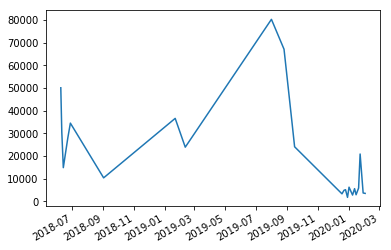

In [65]:
viz_trend_by_time(dat[['date_formatted', 'LIKES']])

In [269]:
def data_process(dat):
    dat['DISLIKES'] = int(str(dat['DISLIKES']).replace('K','000'))
    dat['LIKES'] = int(str(dat['LIKES']).replace(',','').replace('K','000'))
    dat['NUMBER_OF_SUBSCRIPTIONS'] = int(str(dat['NUMBER_OF_SUBSCRIPTIONS']).replace('K','000'))
    dat['NUMBER_OF_VIEWS'] = dat['NUMBER_OF_VIEWS'].split(' ')[0].replace(',','')
    dat['NUMBER_OF_VIEWS'] = int(str(dat['NUMBER_OF_VIEWS']).replace('K','000'))
    return dat

In [281]:
df

{'CHANNEL_NAME': u'TechLead',
 'DATE': u'Sep 19, 2019',
 'DISLIKES': 238,
 'LIKES': u'4,096',
 'NUMBER_OF_SUBSCRIPTIONS': u'548K',
 'NUMBER_OF_VIEWS': u'90,165 views',
 'TITLE': u'Making $150,000/month on YouTube: What it takes to succeed (ft. Graham Stephan).',
 'URL': 'https://youtube.com/watch?v=8JfxhLfqXUM"'}

In [282]:
df['LIKES'] = int(str(df['LIKES']).replace('K','000'))

ValueError: invalid literal for int() with base 10: '4,096'

In [288]:
str(df['LIKES']).replace(',','').replace('K','000')

'4096'

In [11]:
response = requests.get('https://www.youtube.com/watch?v=aZ1G_Q7ovmc')

In [12]:
soup = bs4.BeautifulSoup(response.text)

In [13]:
test = soup.select('.watch-view-count')[0].get_text().split()[0]

In [14]:
test = test.split(',')

In [15]:
test = "".join(test)

In [19]:
int(test)

11229

In [18]:
video_data['views'] = int(soup.select('.watch-view-count')[0].get_text().split()[0])

ValueError: invalid literal for int() with base 10: '11,229'

In [20]:
video_data = {}

In [21]:
video_data['title'] = soup.select('.entry-title a[href^=https:]')[0].get_text()

IndexError: list index out of range

In [22]:
print video_data

{}


In [191]:
video_data['time'] = soup.select('time.published')[0].get_text()

In [193]:
video_data['speakers'] = [a.get_text() for a in soup.select('address.author a[href^=https://pyvideo.org/speaker]')]

In [195]:
video_data['youtube_url'] = [a.attrs.get('href') for a in soup.select('div.details-content a[href^=https://www.youtube.com]')]

In [198]:
response = requests.get(video_data['youtube_url'][0])